# Small Graph Exploration

In [141]:
import plotly.offline as py
from plotly.graph_objs import *

import community
import networkx as nx
import colorlover as cl
import numpy as np
import pickle
import matplotlib.pyplot as plt
import operator

py.init_notebook_mode(connected=True)

# This is your Facebook id. It can also be a number
CENTRAL_ID = 'f8'

In [165]:
friend_graph = {
    'f1': ['f2', 'f3', 'f4', 'f6'],
    'f2': ['f1', 'f4', 'f5', 'f8'],
    'f3': ['f1', 'f4', 'f7', 'f8', 'f9'],
    'f4': ['f1', 'f2', 'f3', 'f5', 'f10'],
    'f5': ['f2', 'f7', 'f8', 'f4'],
    'f6': ['f1', 'f7', 'f8', 'f10'],
    'f7': ['f2', 'f6', 'f8'],
    'f8': ['f2', 'f3', 'f5', 'f6', 'f7', 'f9'],
    'f9': ['f3', 'f8'],
    'f10': ['f4', 'f6']
}

In [166]:
# First, we'll clean the edges of the grap
edges = []
nodes = [CENTRAL_ID]

# Only keep friends with at least 2 common friends
central_friends = {}

for k, v in friend_graph.items():
    # This contains the list number of mutual friends.
    # Doing len(v) does not work because ometimes instead of returning mutual
    # friends, Facebook returns all the person's friends
    intersection_size = len(np.intersect1d(list(friend_graph.keys()), v))
    if intersection_size > 1:
        central_friends[k] = v
        
print('Filtered out {} items'.format(len(friend_graph.keys()) - len(central_friends.keys())))

# Extract edges from graph
for k, v in central_friends.items():
    for item in v:
        if item in central_friends.keys() or item == CENTRAL_ID:
            edges.append((k, item))

Filtered out 0 items


In [167]:
# Create the graph. 
# Small reminder: friends are the nodes and friendships are the edges here
G = nx.Graph()
G.add_nodes_from([CENTRAL_ID])
G.add_nodes_from(central_friends.keys())

G.add_edges_from(edges)
print('Added {} edges'.format(len(edges) ))

Added 39 edges


In [168]:
pos = nx.spring_layout(G)

In [169]:
part = community.best_partition(G)

In [170]:
# Get a list of all node ids
nodeID = G.nodes.keys()

In [171]:
# The louvain community library returns cluster ids, we have turn them into colors using color lovers

colors = cl.scales['12']['qual']['Paired']

def scatter_nodes(pos, labels=None, color='rgb(152, 0, 0)', size=8, opacity=1):
    # pos is the dict of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between [0,1] defining the node color opacity

    trace = Scatter(x=[], 
                    y=[],  
                    mode='markers', 
                    marker=Marker(
        showscale=False,
        colorscale='Greens',
        reversescale=True,
        color=[], 
        size=10,
    line=dict(width=0)))
    for nd in nodeID:
        trace['x'].append(pos[nd][0])
        trace['y'].append(pos[nd][1])
        color = colors[part[nd] % len(colors)]
        trace['marker']['color'].append(color)
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=opacity) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size

    return trace

In [172]:
def scatter_edges(G, pos, line_color='#a3a3c2', line_width=1, opacity=.2):
    trace = Scatter(x=[], 
                    y=[], 
                    mode='lines'
                   )
    for edge in G.edges():
        trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=line_width
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace

In [173]:
# Node label information available on hover. Note that some html tags such as line break <br> are recognized within a string.
labels = []

for nd in nodeID:
      labels.append('{} ({})'.format(nd, part[nd],))

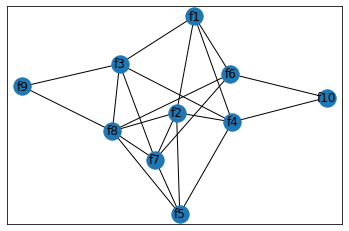

In [174]:
nx.draw_networkx(G)

In [175]:
sp = dict(nx.all_pairs_shortest_path(G))
spl = dict(nx.all_pairs_shortest_path_length(G))
print(sp['f1']['f5'])
print(spl['f6']['f4'])

['f1', 'f2', 'f5']
2


In [176]:
print(spl['f3'])

{'f3': 0, 'f1': 1, 'f4': 1, 'f8': 1, 'f9': 1, 'f7': 1, 'f2': 2, 'f5': 2, 'f6': 2, 'f10': 2}


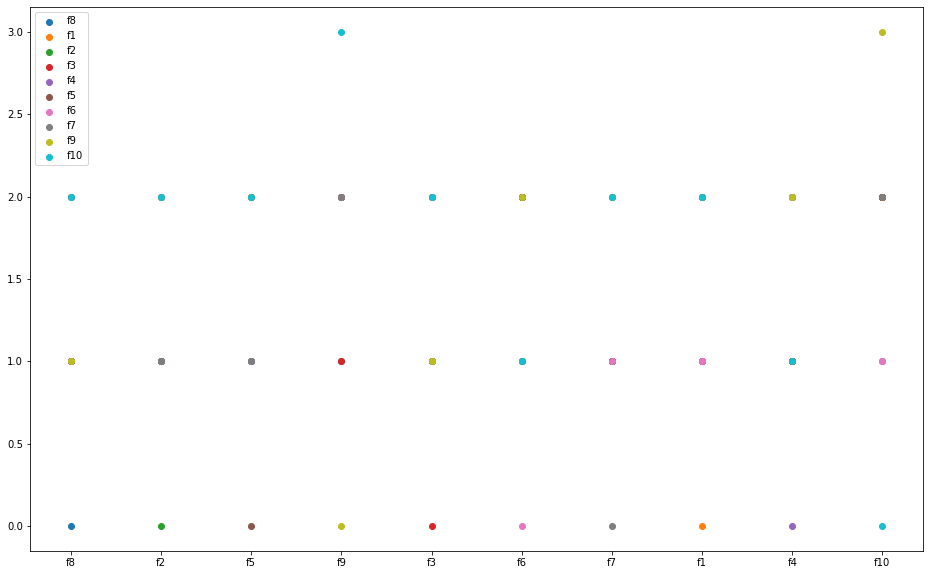

In [182]:
plt.figure(figsize=(16,10))
for data_dict in spl.values():
    x = data_dict.keys()
    y = data_dict.values()
    plt.scatter(x,y)
plt.legend(spl.keys())
plt.show()

In [183]:
for k,v in spl['f1'].items():
    print(k)

f1
f4
f2
f6
f3
f5
f8
f9
f10
f7


In [198]:
# take any node
# and find the nodes that are 2nd degree connections from it

def find_second_deg(selected_node):
    
    potential_matches = []
    closeness_dict = {}
    for k, v in spl[selected_node].items():
        if v == 2:
            # create list of node names
            potential_matches.append(k)
        if v == 1 or v == 2:
            closeness_dict[k] = v
    return potential_matches, closeness_dict

In [199]:
selected_node = 'f1'
potential_matches, closeness_dict = find_second_deg(selected_node)

In [200]:
closeness_dict

{'f4': 1,
 'f2': 1,
 'f6': 1,
 'f3': 1,
 'f5': 2,
 'f8': 2,
 'f9': 2,
 'f10': 2,
 'f7': 2}

In [201]:
potential_matches
# we iterate through our potential matches
# counting up the number of 1st or 2nd connections they SHARE
# with the selected node, using closeness list as the list of shares
# 1 is worth 1.5 points, 2 is worth 1 point.
def shared_close_matches(potential_matches, closeness_dict):
    
    match_dict = {}
    
    match_counter = 0
    # iterate through potential matches
    for match in potential_matches:
        
        # for each match, evaluate closeness to selection
        # using closeness_list
        if match in closeness_dict.keys():
            
            if dict(closeness_dict.items())[match] == 1:
                match_counter+= 1.5
            elif dict(closeness_dict.items())[match] == 2:
                match_counter+= 1
            
            # store match counter
            match_dict[match] = match_counter
    
    return match_dict


In [202]:
stats = shared_close_matches(potential_matches, closeness_dict)
print(stats)

{'f5': 1, 'f8': 2, 'f9': 3, 'f10': 4, 'f7': 5}


In [203]:
max(stats.items(), key=operator.itemgetter(1))[0]

'f7'

In [207]:
def find_matches_in_order(selected_node):
    potential_matches, closeness_dict = find_second_deg(selected_node)
    stats = shared_close_matches(potential_matches, closeness_dict)
    return stats, max(stats.items(), key=operator.itemgetter(1))[0]

In [213]:
selected_node = 'f6'
stats, best_match = find_matches_in_order(selected_node)
print(stats)
print('Best match for ' + selected_node + ' is', best_match)

{'f2': 1, 'f4': 2, 'f5': 3, 'f9': 4, 'f3': 5}
Best match for f6 is f3


Just using the layout of the network, we can find the most likely friend that is a good match for our selected user.

Note, this is using no user preferences. Ideally we would have independent variables that we could layer on top of this for a more elaborate 'match_counter' or 'elo' would be things like gender, sexual preferences, interests, closeness in proximity, etc.